/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.7087777256965637, Train Acc: 0.501893937587738, Val Loss: 0.4504069685935974, Val Acc: 0.9015151262283325
Epoch 2, Train Loss: 0.3615201711654663, Train Acc: 0.9318181872367859, Val Loss: 0.3194151818752289, Val Acc: 0.9128788113594055
Epoch 3, Train Loss: 0.17890091240406036, Train Acc: 0.9592803120613098, Val Loss: 0.3261626362800598, Val Acc: 0.8901515007019043
Epoch 4, Train Loss: 0.09472791850566864, Train Acc: 0.9876893758773804, Val Loss: 0.29536208510398865, Val Acc: 0.8977272510528564
Epoch 5, Train Loss: 0.046734072268009186, Train Acc: 0.998106062412262, Val Loss: 0.2883557975292206, Val Acc: 0.9015151262283325
Epoch 6, Train Loss: 0.027302902191877365, Train Acc: 0.998106062412262, Val Loss: 0.32850149273872375, Val Acc: 0.8825757503509521
Epoch 7, Train Loss: 0.017894595861434937, Train Acc: 0.9990530014038086, Val Loss: 0.33737844228744507, Val Acc: 0.8825757503509521
Epoch 8, Train Loss: 0.012774479575455189, Train Acc: 1.0, Val Loss: 0.36289381980

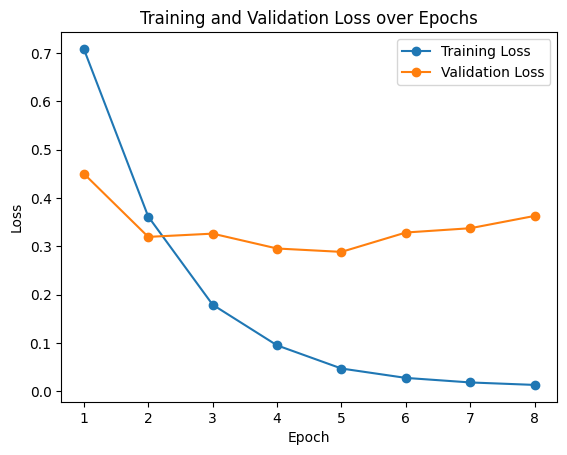

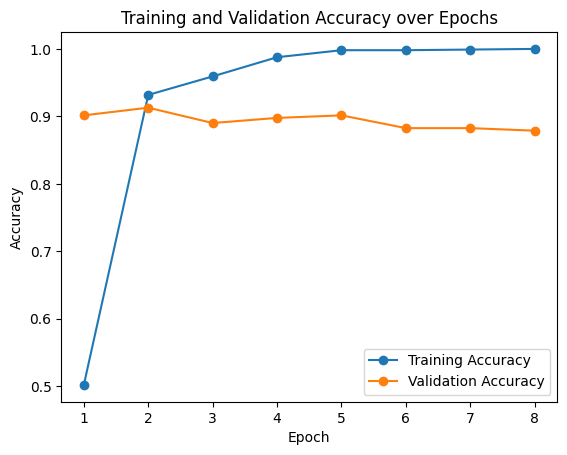

Precision: 0.2600
Recall: 0.2800
F1 Score: 0.2667


/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [1]:
""" 

Train and validation datasets involves splitting the data into two separate parts:

- Training Set: This portion of the data is used to train or fit the model. The model learns patterns, relationships, and features from this data.

- Validation Set: This part is used to evaluate the model's performance during training. 
It helps in tuning parameters and assessing how well the model generalizes to unseen data, which is not used for learning but for validation.

The primary goal of this split is to ensure that the model can generalize well to new, unseen data and is not just memorizing the training data.

The Early Stopping is here to monitor validation loss and stops training if no improvement is observed for a set number of epochs, 
saving the best-performing model.

Performance Metrics are plotted and displayed to evaluate the final model using precision, recall, and F1 score, 
which are critical for multi-label classification tasks where correct label prediction matters for multiple labels per image.

"""

import os
import torch
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import numpy as np

# Custom dataset class
class ArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(self.labels['labels'].apply(lambda x: x.split(', ')))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.labels.iloc[idx, 1].split(', ')
        labels = self.mlb.transform([labels])[0]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels, dtype=torch.float32)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = ArtDataset(csv_file='dataset/labelsalgomix.csv', root_dir='dataset/train', transform=transform)

# Split dataset into training and validation
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(full_dataset.mlb.classes_))

# Training
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds == labels).float().sum()
    return correct / labels.numel()

early_stopping_patience = 3
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        running_train_acc += calculate_accuracy(outputs, labels).item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            running_val_acc += calculate_accuracy(outputs, labels).item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = running_val_acc / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Acc: {epoch_train_acc}, Val Loss: {epoch_val_loss}, Val Acc: {epoch_val_acc}')

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_art_model_algomix.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('best_art_model_algomix.pth'))

# Plot loss graph
plt.figure()
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot accuracy graph
plt.figure()
plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate model
def evaluate_model(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# Get predictions and true labels for validation set
val_labels, val_preds = evaluate_model(val_loader)

# Convert lists to arrays
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')

# Display results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [4]:
### RUN BEST ART MODEL

import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from torchvision import transforms

# Load the fine-tuned model
model.load_state_dict(torch.load('best_art_model_algomix.pth'))
model.eval()

# Load CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device)

# Define the same transform used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load your CSV file
df = pd.read_csv('dataset/labelsalgomix.csv')

# Initialize an empty dictionary to hold your keyword-to-algorithm mappings
keyword_to_algo = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    labels = [label.strip().lower() for label in row['labels'].split(", ")]
    algorithm = labels[0]  # Assuming the first label is always the algorithm

    # Map each label to the algorithm
    for label in labels:
        keyword_to_algo[label] = algorithm


# Function to predict and verify descriptions
def predict_and_verify(image_path, model, clip_model, clip_processor, mlb, keyword_to_algo):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    
    # Preprocess the image for the classification model
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Predict keywords
    with torch.no_grad():
        output = model(input_image)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        top_indices = probs.argsort()[-5:][::-1]  # Top 5 keywords
        keywords = [mlb.classes_[idx] for idx in top_indices]
    
    # Preprocess the image for CLIP
    clip_image_input = clip_processor(image).unsqueeze(0).to(device)
    
    # Encode image and generated keywords with CLIP
    text_inputs = torch.cat([clip.tokenize(keyword) for keyword in keywords]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_image_input)
        text_features = clip_model.encode_text(text_inputs)
    
    # Compute similarities
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]
    
    # Refine and return top keywords
    refined_keywords = sorted(zip(keywords, similarities), key=lambda x: x[1], reverse=True)[:5]
    top_keywords = [kw[0] for kw in refined_keywords]
    
    # Map keywords to algorithms
    algorithm_count = {}
    for keyword in top_keywords:
        keyword_lower = keyword.lower()
        algorithm = keyword_to_algo.get(keyword_lower, None)
        if algorithm:
            if algorithm in algorithm_count:
                algorithm_count[algorithm] += 1
            else:
                algorithm_count[algorithm] = 1

    # Choose the algorithm that appears most frequently
    if algorithm_count:
        final_algorithm = max(algorithm_count, key=algorithm_count.get)
    else:
        final_algorithm = None

    return top_keywords, final_algorithm

# Example usage
image_path = "../images/algorithm_b.png"
keywords, algorithm = predict_and_verify(image_path, model, clip_model, clip_preprocess, full_dataset.mlb, keyword_to_algo)

print("Predicted Keywords:", keywords)
print("Mapped Algorithm:", algorithm)


Predicted Keywords: ['reaction diffusion', 'mandelbrot', 'intricate', 'structured', 'Metallic']
Mapped Algorithm: reaction diffusion


In [10]:
# Running the best model on a larger sample to get the occurences

import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from torchvision import transforms

# Load the fine-tuned model
model.load_state_dict(torch.load('best_art_model_algomix.pth'))
model.eval()

# Load CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device)

# Define the same transform used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load your CSV file
df = pd.read_csv('dataset/labelsalgomix.csv')

# Initialize an empty dictionary to hold your keyword-to-algorithm mappings
keyword_to_algo = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    labels = [label.strip().lower() for label in row['labels'].split(", ")]
    algorithm = labels[0]  # Assuming the first label is always the algorithm

    # Map each label to the algorithm
    for label in labels:
        keyword_to_algo[label] = algorithm

# Initialize dictionaries to count occurrences
keyword_occurrences = {}
algorithm_occurrences = {}

# Function to predict and verify descriptions
def predict_and_verify(image_path, model, clip_model, clip_processor, mlb, keyword_to_algo):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    
    # Preprocess the image for the classification model
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Predict keywords
    with torch.no_grad():
        output = model(input_image)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        top_indices = probs.argsort()[-5:][::-1]  # Top 5 keywords
        keywords = [mlb.classes_[idx] for idx in top_indices]
    
    # Preprocess the image for CLIP
    clip_image_input = clip_processor(image).unsqueeze(0).to(device)
    
    # Encode image and generated keywords with CLIP
    text_inputs = torch.cat([clip.tokenize(keyword) for keyword in keywords]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_image_input)
        text_features = clip_model.encode_text(text_inputs)
    
    # Compute similarities
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]
    
    # Refine and return top keywords
    refined_keywords = sorted(zip(keywords, similarities), key=lambda x: x[1], reverse=True)[:5]
    top_keywords = [kw[0] for kw in refined_keywords]
    
    # Map keywords to algorithms
    algorithm_count = {}
    for keyword in top_keywords:
        keyword_lower = keyword.lower()
        algorithm = keyword_to_algo.get(keyword_lower, None)
        if algorithm:
            if algorithm in algorithm_count:
                algorithm_count[algorithm] += 1
            else:
                algorithm_count[algorithm] = 1

    # Choose the algorithm that appears most frequently
    if algorithm_count:
        final_algorithm = max(algorithm_count, key=algorithm_count.get)
    else:
        final_algorithm = None

    return top_keywords, final_algorithm

# Iterate over all images
for i in range(1, 51):  # Assuming you have 50 images named sequentially
    image_path = f"ipfs/image{i}.png"
    keywords, algorithm = predict_and_verify(image_path, model, clip_model, clip_preprocess, full_dataset.mlb, keyword_to_algo)

    # Update keyword occurrences
    for keyword in keywords:
        if keyword in keyword_occurrences:
            keyword_occurrences[keyword] += 1
        else:
            keyword_occurrences[keyword] = 1

    # Update algorithm occurrences
    if algorithm:
        if algorithm in algorithm_occurrences:
            algorithm_occurrences[algorithm] += 1
        else:
            algorithm_occurrences[algorithm] = 1

# Print the final occurrences
print("Keyword Occurrences:", keyword_occurrences)
print("Algorithm Occurrences:", algorithm_occurrences)


Keyword Occurrences: {'flowers': 7, 'fractal': 33, 'intricate': 42, 'L-Systems': 4, 'mandelbrot': 4, 'structured': 36, 'reflective': 30, 'Metallic': 30, 'reaction diffusion': 11, 'Perlin noise': 5, 'motion': 7, 'link': 1, 'stripes': 6, 'gravity': 1, 'pattern': 12, 'swirls': 5, 'lines': 5, 'vertex': 2, 'cube': 1, 'square': 2, 'segemented': 1, 'polygonal': 1, 'hyptnotic': 1, 'glitch': 1, 'Circular': 1, 'flow': 1}
Algorithm Occurrences: {'mandelbrot': 17, 'reaction diffusion': 25, 'perlin noise': 7, 'l-systems': 1}
